In [60]:
import os
import os.path as osp
import dotenv
import pandas as pd
import numpy as np
import dotenv
import collections
from snorkel import SnorkelSession

dotenv.load_dotenv('../env.sh')
%run ../src/supervision.py
session = SnorkelSession()

<Figure size 432x288 with 0 Axes>

In [2]:
from snorkel.models import Candidate
classes = get_candidate_classes()
c = session.query(classes.inducing_cytokine.subclass).first()
c.get_cids(), c.cytokine_cid, c.immune_cell_type_cid

(('CKC645FE6112316D36:CK64C4AB510CA1ACA7',
  'CTA435D07EA4694572:CTFE4015328B70D553'),
 'CKC645FE6112316D36:CK64C4AB510CA1ACA7',
 'CTA435D07EA4694572:CTFE4015328B70D553')

In [3]:
import re
from snorkel.lf_helpers import (
    get_tagged_text,
    rule_regex_search_tagged_text,
    rule_regex_search_btw_AB,
    rule_regex_search_btw_BA,
    rule_regex_search_before_A,
    rule_regex_search_before_B,
)
#from snorkel.lf_helpers import get_text_splits
#??get_text_splits

### Text Pattern Functions

In [4]:
def ltp(x):
    x = [v for v in x if v]
    return '(' + '|'.join(x) + ')'

terms = {
    'r_diff': [
        # noun, verb (present or 3rd person present), verb (past or participle), gerund
        ('differentiation', 'differentiate', 'differentiated', 'differentiating'), 
        ('formation', 'form', 'formed', 'forming'), 
        ('generation', 'generate', 'generated', 'generating'),
        ('polarization', 'polarize', 'polarized', 'polarizing'),
        ('development', 'develop', 'developed', 'developing'),
        ('induction', None, None, None),
    ],
    'r_push': [
        ('inducer', 'induce', 'induced', 'inducing'),
        ('driver', 'drive', 'drove|driven', 'driving'),
        ('director', 'direct', 'directed', 'directing'),
        ('regulator', 'regulate', 'regulated', 'regulating'),
        ('promoter', 'promote', 'promoted', 'promoting'),
    ],
    'r_prod': [
        ('producer|production', 'produce', 'produced', 'producing'),
        ('generator|generation', 'generate', 'generated', 'generating'),
        ('creator|creation', 'create', 'created', 'creating'),
    ],
    'r_secr': [
        ('secretor|secretion', 'secrete', 'secreted', 'secreting'),
        ('expressor|expression', 'express', 'expressed', 'expressing'),
        ('producer|production', 'produce', 'produced', 'producing'),
        ('releaser|release', 'release', 'released', 'releasing'),
    ]
}
terms_map = {}
for k, v in terms.items():
    terms_map[k+'_n'] = ltp([r[0] for r in v])
    terms_map[k+'_v'] = ltp([r[1] for r in v] +[r[1]+('es' if r[1].endswith('s') else 's') for r in v if r[1]])
    terms_map[k+'_p'] = ltp([r[2] for r in v])
    terms_map[k+'_g'] = ltp([r[3] for r in v])
    
terms_map['n_do'] = '(cannot|can\'t|will not|won\'t|does not|doesn\'t|do not|don\'t)'
terms_map['wc_sm'] = '.{0,30}'
terms_map['wc_md'] = '.{0,50}'
terms_map['wc_lg'] = '.{0,150}'
terms_map['wc_xl'] = '.{0,250}'
terms_map

{'r_diff_n': '(differentiation|formation|generation|polarization|development|induction)',
 'r_diff_v': '(differentiate|form|generate|polarize|develop|differentiates|forms|generates|polarizes|develops)',
 'r_diff_p': '(differentiated|formed|generated|polarized|developed)',
 'r_diff_g': '(differentiating|forming|generating|polarizing|developing)',
 'r_push_n': '(inducer|driver|director|regulator|promoter)',
 'r_push_v': '(induce|drive|direct|regulate|promote|induces|drives|directs|regulates|promotes)',
 'r_push_p': '(induced|drove|driven|directed|regulated|promoted)',
 'r_push_g': '(inducing|driving|directing|regulating|promoting)',
 'r_prod_n': '(producer|production|generator|generation|creator|creation)',
 'r_prod_v': '(produce|generate|create|produces|generates|creates)',
 'r_prod_p': '(produced|generated|created)',
 'r_prod_g': '(producing|generating|creating)',
 'r_secr_n': '(secretor|secretion|expressor|expression|producer|production|releaser|release)',
 'r_secr_v': '(secrete|expre

In [5]:
# Induction - Positive

def subst_pattern(pattern, terms=None):
    for k, v in {**terms_map, **(terms or {})}.items():
        pattern = pattern.replace('{{' + k + '}}', v)
    return pattern

def regex_pattern(pattern, terms=None):
    return regex_search(None, pattern, terms=terms, pattern_only=True)
    
def regex_search(c, pattern, terms=None, pattern_only=False):
    # Add possible "cell" token after each cell type reference
    pattern = pattern.replace('{{B}}', '{{B}}( cell| type cell|-type cell)?')
    
    # Apply generic replacements in pattern
    pattern = subst_pattern(pattern, terms=terms)
    
    if pattern_only:
        return pattern
    return rule_regex_search_tagged_text(c, pattern, 1)

def LF_ind_pos_1(c):
    # predominance of [cytokine] drives [cell type] differentiation
    # [cytokine] regulates [cell type] differentiation
    return regex_search(c, r'{{A}}{{wc_md}}{{r_push_v}}{{wc_md}}{{B}}{{wc_md}}{{r_diff_n}}')

def LF_ind_pos_2(c):
    # Furthermore, a key inducer of both [cell type] and [cell type] cell differentiation, [cytokine] ...
    return regex_search(c, r'{{r_push_n}} of {{wc_md}}{{B}}{{wc_md}}{{r_diff_n}}{{wc_md}}{{A}}')

def LF_ind_pos_3(c):
    # [cytokine] has been shown to induce [cell type] cell differentiation
    # [cytokine] and [cytokine] induce [cell type] cell differentiation
    return regex_search(c, r'{{A}}{{wc_md}} {{r_push_v}} {{B}} {{r_diff_n}}')

def LF_ind_pos_4(c):
    # whereas [cytokine], critical for [cell type] and [cell type] cell induction
    # revealed that [cytokine] was an essential cytokine in mediating [cell type] cell development
    return regex_search(c, r'{{A}}{{wc_md}} (critical|essential|important) {{wc_md}}{{B}} {{r_diff_n}}')

def LF_ind_pos_5(c):
    # The role of [cytokine] ... to its ability to polarize T-helper cells toward the [cell type] type
    return regex_search(c, r'{{A}}{{wc_lg}}ability to {{r_diff_v}}{{wc_md}}toward{{wc_md}}{{B}}')

def LF_ind_pos_6(c):
    # [cell type] … driven by [cytokine]
    return regex_search(c, r'{{B}}{{wc_lg}} {{r_push_p}} (by|via|using|through) {{A}}')

def LF_ind_pos_7(c):
    # [cytokine] regulates [cell type] differentiation
    return regex_search(c, r'{{A}}{{wc_md}} (regulate[s]?|control[s]?) {{wc_md}}{{B}} {{r_diff_n}}')

def LF_ind_pos_8(c):
    # lacking other molecules involved in [cell type] differentiation, such as [cytokine]
    return regex_search(c, r'{{B}} {{r_diff_n}}[,]?{{wc_md}}(such as|like|including){{wc_md}}{{A}}')

def LF_ind_pos_9(c):
    # [cytokine], a component of the [cell type] paradigm
    return regex_search(c, r'{{A}}[,]?{{wc_md}}(component|part|constituent) of the {{B}}')

def LF_ind_pos_10(c):
    # confirms that [cytokine] is a critical cytokine in the commitment to [cell type] 
    return regex_search(c, r'{{A}}{{wc_lg}}(critical|essential){{wc_lg}}commitment to {{B}}')

def LF_ind_pos_11(c):
    # cells exposed to [cytokine] can … develop into [cell type]
    return regex_search(c, r'{{A}}{{wc_lg}}{{r_diff_v}} into {{B}}')

def LF_ind_pos_12(c):
    # [cell type] cells require [cytokine] for their generation
    return regex_search(c, r'{{B}}{{wc_lg}} (need[s]?|require[s]?) {{wc_lg}}{{A}}{{wc_lg}}{{r_prod_n}}')

def LF_ind_pos_13(c):
    # [cytokine] is important for differentiation of [cell type]
    return regex_search(c, r'{{A}}{{wc_lg}}(critical|essential|important){{wc_md}}{{r_diff_n}}{{wc_md}}{{B}}')
    
def LF_ind_pos_14(c):
    # [cytokine] induce(s) the development of [cell type]
    # [cytokine] promote(s) differentiation into [cell type]
    return regex_search(c, r'{{A}} {{r_push_v}}{{wc_sm}}{{r_diff_n}} (of|into) {{B}}')

def LF_ind_pos_15(c):
    # the receptors for [cytokine] are required for [cell type] differentiation
    return regex_search(c, r'receptors for{{wc_md}}{{A}}{{wc_md}}(needed|required|necessary for){{wc_md}}{{B}}{{wc_md}}{{r_diff_n}}')

def LF_ind_pos_16(c):
    # impaired human [cell type] differentiation when [cytokine] was blocked
    return regex_search(c, r'{{B}}{{wc_md}}{{r_diff_n}}{{wc_md}}when {{B}}{{wc_md}}blocked')

def LF_ind_pos_17(c):
    # [other cytokine] expression is required for [other cell type] differentiation, [cytokine] for [cell type] differentiation
    return regex_search(c, r'{{A}} for {{B}}{{wc_md}}{{r_diff_n}}')

def LF_ind_pos_18(c):
    # in [cell type] differentiation, a process driven by [cytokine]
    return regex_search(c, r'{{B}}{{wc_md}}{{r_diff_n}}{{wc_md}}{{r_push_p}} by {{A}}')

def LF_ind_pos_19(c):
    # role of [cytokine] in [cell type] differentiation
    return regex_search(c, r'role of {{A}}{{wc_md}}{{B}}{{wc_md}}{{r_diff_n}}')

def LF_ind_pos_20(c):
    # role of [cytokine] in [cell type] differentiation
    # effects of [cytokine] in [cell type] differentiation
    return regex_search(c, r'(effects|role) of {{A}}{{wc_md}}{{B}}{{wc_md}}{{r_diff_n}}')

def LF_ind_pos_21(c):
    # [cytokine] … initiate [cell type] differentiation
    return regex_search(c, r'{{A}}{{wc_md}}(initiate|trigger|induce){{wc_md}}{{B}}{{wc_md}}{{r_diff_n}}')

def LF_ind_pos_22(c):
    # [cytokine] is the most potent factor that causes [other ct] to differentiate to the [cell type] phenotype
    return regex_search(c, r'{{A}}{{wc_md}}(cause|lead|force){{wc_md}}{{r_diff_v}}{{wc_md}} (in)?to( the)? {{B}}')

def LF_ind_pos_23(c):
    # we show that [cytokine], probably secreted by APC cells, is able to polarize naive CD4+ T cells to [cell type] cells
    return regex_search(c, r'{{A}}{{wc_md}}{{r_secr_p}}cells{{wc_md}}{{r_diff_v}}{{wc_md}}{{B}}')

def LF_ind_pos_24(c):
    # It is clear that the cytokine [cytokine] directs differentiation to a [cell type] phenotype 
    # while IL-4 can drive differentiation to a Th2 phenotype
    return regex_search(c, r'{{A}}{{wc_md}}{{r_push_v}}{{wc_md}}{{r_diff_n}}{{wc_md}}{{B}}')

def LF_ind_pos_25(c):
    # upregulating IL-4 production and inhibiting IFN-γ production, thereby polarizing the differentiation of Th2 cells.
    return regex_search(c, r'{{A}} production{{wc_md}}thereby polarizing{{wc_md}}{{r_diff_n}}{{wc_md}}{{B}}')

def LF_ind_pos_26(c):
    # we show that IL-6 is able to initiate the polarization of naive CD4+ T cells to effector Th2
    return regex_search(c, r'{{A}}{{wc_sm}}{{initiate}}{{wc_sm}}{{r_diff_n}}{{wc_md}}{{B}}', {
        'initiate': '(initiate|start|cause|begin|commence|catalyze)'
    })

def LF_ind_pos_27(c):
    # the [cytokine]– mediated differentiation of [cell type] cells
    return regex_search(c, r'{{A}}.{0,10}mediated {{r_diff_n}}{{wc_md}}{{B}}')

def LF_ind_pos_28(c):
    # [cytokine] Directs the Differentiation of [cell type] Cells.
    return regex_search(c, r'{{A}}{{wc_sm}}{{r_push_v}}{{wc_sm}}{{r_diff_n}}{{wc_sm}}{{B}}')



In [6]:
# Induction - Negative

def LF_ind_neg_1(c):
    # [cytokine] cannot produce [cell type] cells de novo from naïve T cells 
    return -1*regex_search(c, r'{{wc_md}}{{A}}{{wc_md}}{{n_do}} {{r_prod_v}}{{wc_md}}{{B}}')

def LF_ind_neg_2(c):
    # [cell type] cells do not respond to [cytokine]
    return -1*regex_search(c, r'{{B}}{{wc_md}} {{n_do}} (respond|react) to {{wc_md}}{{A}}')

def LF_ind_neg_3(c):
    # Vote negative when some kind of contrasting or punctuating clause exists between references
    # expressed high levels of [cytokine]; compared to adult subsets, [cell type]
    # [cytokine] is instrumental in directing [cell type] differentiation, whereas [cytokine] promotes [cell type] differentiation
    return -1*regex_search(c, r'{{A}}{{wc_lg}} (;|:|whereas|however|although) {{wc_lg}}{{B}}')

def LF_ind_neg_4(c):
    # cells cultured in [cytokine] or low-dose IL-2 never developed into full-fledged [cell type] cells
    return -1*regex_search(c, r'{{A}}{{wc_md}}({{n_do}}|(never)){{wc_md}}{{r_diff_v}}{{wc_md}}{{B}}')

def LF_ind_neg_5(c):
    # *References to endogenous cytokines rarely make sense in the context of polarization
    # of endogenous [cytokine]
    return -1*regex_search(c, r'(endogenous|intracellular|intra-cellular){{wc_sm}}{{A}}')

def LF_ind_neg_6(c):
    # [cytokine] also antagonizes the [other cytokine]– mediated differentiation of [cell type] cells
    return -1*regex_search(c, r'{{A}}{{wc_lg}}(antagonizes|inhibits){{wc_lg}}{{B}}')
    
def LF_ind_bth_1(c):
    # Return signed result for whether or not mention of cytokine is at most X chars before cell type mention
    return 1 if re.search(r'{{A}}.{0,150}{{B}}', get_tagged_text(c), flags=re.I) else -1

In [7]:
# Secretion 

def LF_sec_pos_1(c):
    # ... regulates [cell type] differentiation, inducing [cytokine] expression
    return regex_search(c, r'{{B}}{{wc_md}}{{r_diff_n}}{{wc_md}}{{r_push_g}}{{wc_sm}}{{A}}{{wc_sm}}{{r_secr_n}}')

def LF_sec_pos_2(c):
    # [cell type] cells produce [cytokines]
    # [cell type] cells, which secrete [cytokine]
    return regex_search(c, r'{{B}}{{wc_md}}{{r_secr_v}}{{wc_sm}}{{A}}')

def LF_sec_pos_3(c):
    # induced [cell type] cell expansion and [cytokine] release
    return regex_search(c, r'{{B}}{{wc_md}}{{A}}{{wc_sm}}{{r_secr_n}}')

def LF_sec_pos_4(c):
    # Considerable amounts of [cytokine] were released by the [cell type] cells
    # significantly higher levels of [cytokine] were secreted by [cell type]
    return regex_search(c, r'{{A}}{{wc_md}}{{r_secr_p}}{{wc_md}}{{B}}')

def LF_sec_pos_5(c):
    # [cell type] cells secreted significantly higher levels of [cytokine]
    return regex_search(c, r'{{B}}{{wc_md}}{{r_secr_p}}{{wc_md}}{{A}}')

def LF_sec_pos_6(c):
    # by inducing the initial production of [cytokine] in [cell type] cells
    return regex_search(c, r'{{r_secr_n}} of {{A}}{{wc_sm}}{{B}}')

def LF_sec_pos_7(c):
    # while [cell type] are the main source of [cytokine]
    return regex_search(c, r'{{B}}{{wc_sm}}{{primary}}{{wc_sm}}{{provider}}{{wc_sm}}{{A}}', {
        'primary': '(main|primary|typical|conventional|usual|consistent)',
        'provider': '(source|provider|producer|generator|creator|supplier)'
    })


def LF_sec_bth_1(c):
    # Return signed result for whether or not mention of cell type is at most X chars before cytokine mention
    return 1 if re.search(r'{{B}}.{0,250}{{A}}', get_tagged_text(c), flags=re.I) else -1

In [8]:
# text = 'deficient in IL12A ({{A}}), a component of the {{B}} paradigm'
# pattern = regex_pattern(r'{{A}}[,]?{{wc_md}}(component|part|constituent) of the {{B}}')
# print(pattern)
# m = re.search(pattern, text, flags=re.I)
# m is not None, m

In [9]:
# Show frequency of cytokine tagged in dev set
#pd.Series([c.cytokine.get_span() for c in dev_cands]).value_counts().sort_values()

### Distant Supervision Functions

In [10]:
df_ix = pd.read_csv(osp.join(os.environ['SUPERVISION_DATA_DIR'], 'immunexpresso', 'data.csv'))

# Filter to records with known cell/cytokine mappings for internal IDS
df_ix = df_ix[df_ix['cell_ref_id'].notnull() & df_ix['cytokine_ref_id'].notnull()]
# Also filter to records with >= 5 publications, as classification is a bit noisy
df_ix = df_ix[df_ix['num_papers'] >= 5]
print(df_ix.info())
df_ix = df_ix.set_index(['cell_ref_id', 'cytokine_ref_id']).sort_index()

def is_known_ix_relation(c, actor, category):
    # Actor = 'cytokine' implies induction relationship where category in ['Positive', 'Negative', 'Unknown']
    # Actor = 'cell' implies secreation relationship and category is always 'Positive'
    
    # Split ids saved as "<matched id>:<preferred id>" to do lookup on preferred id
    ct_id, ck_id = c.immune_cell_type_cid, c.cytokine_cid
    ct_id, ck_id = ct_id.split(':')[1], ck_id.split(':')[1]
    if (ct_id, ck_id) in df_ix.index:
        df = df_ix.loc[(ct_id, ck_id)]
        df = df[(df['actor'] == actor) & (df['category'] == category)]
        return len(df) > 0
    return None

def LF_ind_pos_imexpresso(c):
    ind1 = is_known_ix_relation(c, 'cytokine', 'Positive')
    if ind1 is None:
        return 0
    ind2 = is_known_ix_relation(c, 'cytokine', 'Negative')
    ind3 = is_known_ix_relation(c, 'cell', 'Positive')
    if ind1:
        return 1
    if ind2 or ind3:
        return -1
    return 0

def LF_sec_pos_imexpresso(c):
    ind1 = is_known_ix_relation(c, 'cell', 'Positive')
    if ind1 is None:
        return 0
    ind2 = is_known_ix_relation(c, 'cytokine', 'Positive')
    ind3 = is_known_ix_relation(c, 'cytokine', 'Negative')
    if ind1:
        return 1
    if ind2 or ind3:
        return -1
    return 0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136 entries, 13 to 329
Data columns (total 10 columns):
actor              136 non-null object
category           136 non-null object
cell_id            136 non-null object
cell_label         136 non-null object
cytokine_id        136 non-null object
cytokine_label     136 non-null object
num_papers         136 non-null int64
score              136 non-null float64
cell_ref_id        136 non-null object
cytokine_ref_id    136 non-null object
dtypes: float64(1), int64(1), object(8)
memory usage: 11.7+ KB
None


In [67]:
#df_ix.head()

In [14]:
dft = df_ix[(df_ix['actor'] == 'cytokine') & (df_ix['category'] == 'Positive')].sort_values('num_papers', ascending=False)
dft[dft['cell_label'] == 'T-helper 1 cell'].head(10)

actor  category     cell_id  \
cell_ref_id        cytokine_ref_id                                      
CTC3A8C3CBC245616A CKB4EB2D2CC8BBB93D  cytokine  Positive  CL_0000545   
                   CK128EC732B281BF60  cytokine  Positive  CL_0000545   
                   CKC5CC1A269C01EC48  cytokine  Positive  CL_0000545   
                   CK6FE135B3F86FB707  cytokine  Positive  CL_0000545   
                   CKBF6003C60D23BA0D  cytokine  Positive  CL_0000545   
                   CKBA47332D395669A3  cytokine  Positive  CL_0000545   
                   CK4FB12B98006424AF  cytokine  Positive  CL_0000545   
                   CKD21834C7D75FD77F  cytokine  Positive  CL_0000545   

                                            cell_label cytokine_id  \
cell_ref_id        cytokine_ref_id                                   
CTC3A8C3CBC245616A CKB4EB2D2CC8BBB93D  T-helper 1 cell      CID_95   
                   CK128EC732B281BF60  T-helper 1 cell      CID_83   
                   CKC5CC1A269C01EC48  T-helper 1 cell      CID_93   
                   CK6FE135B3F86FB707  T-helper 1 cell     CID_131   
                   CKBF6003C60D23BA0D  T-helper 1 cell     CID_108   
                   CKBA47332D395669A3  T-helper 1 cell     CID_500   
                   CK4FB12B98006424AF  T-helper 1 cell      CID_97   
                   CKD21834C7D75FD77F  T-helper 1 cell     CID_110   

                                      cytokine_label  num_papers  score  
cell_ref_id        cytokine_ref_id                                       
CTC3A8C3CBC245616A CKB4EB2D2CC8BBB93D           IL12          56  11.77  
                   CK128EC732B281BF60           IFNG          18   0.68  
                   CKC5CC1A269C01EC48           IL10          13   1.29  
                   CK6FE135B3F86FB707            IL4           7   0.84  
                   CKBF6003C60D23BA0D           IL18           7   4.63  
                   CKBA47332D395669A3           IL27           6   9.06  
                   CK4FB12B98006424AF          IL12B           5  22.07  
                   CKD21834C7D75FD77F            IL2           5   0.27

#### LF Testing

In [12]:
# c = session.query(candidate_class).filter(candidate_class.id == 32753).all()[0]
# c

In [123]:
c.cytokine_cid, c.immune_cell_type_cid

('CKB4EB2D2CC8BBB93D:CKB4EB2D2CC8BBB93D',
 'CTC3A8C3CBC245616A:CTC3A8C3CBC245616A')

In [129]:
#df_ix.loc['CTC3A8C3CBC245616A']

In [130]:
#df_ix.loc[('CTC3A8C3CBC245616A', 'CKB4EB2D2CC8BBB93D')]

In [62]:
L_dev = load_gold_labels(
    session, annotator_name=candidate_class.field, 
    split=1, load_as_array=False, 
    cids_query=get_cids_query(session, candidate_class, 1)
)

In [70]:
from snorkel.viewer import SentenceNgramViewer
labeled = []
candidate_class = classes.inducing_cytokine
# Load all dev labels for this relation class
L_dev = load_gold_labels(
    session, annotator_name=candidate_class.field, 
    split=1, load_as_array=False, 
    cids_query=get_cids_query(session, candidate_class, 1)
)
# Filter to get list of candidates where label is positive
L_dev_pos_cands = [L_dev.get_candidate(session, i) for i in np.argwhere(L_dev.toarray().squeeze()).squeeze()]

In [71]:
cands = session.query(candidate_class.subclass).filter(candidate_class.subclass.split == 1).all()
for c in cands:
#     if LF_ind_pos_2(c) != 0:
#         labeled.append(c)
    if LF_ind_pos_imexpresso(c) == 1:
        labeled.append(c)
print("Number labeled:", len(labeled))
# - ID in hover state is sentence id (c.get_parent().id)
SentenceNgramViewer(labeled, session, gold=L_dev_pos_cands)

Number labeled: 252


<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[51, 52], [8, 9], []], [[60], [0, 16], [142, 158, 166]], [[74], [4, 5, 165, 175, 17…

### Composite Functions

In [15]:
def get_lfs(filter_fn=None):
    if filter_fn is None:
        filter_fn = lambda k: True
    gl = globals()
    lfs = [v for k, v in gl.items() if callable(v) and filter_fn(k)]
    return sorted(lfs, key=lambda f: f.__name__)

funs_ind_neg_sec = get_lfs(lambda k: k.startswith('LF_sec_pos'))
print('LF_ind_neg_sec: Num functions composed = {} (names = {})'.format(
    len(funs_ind_neg_sec), [f.__name__ for f in funs_ind_neg_sec]
))

def LF_ind_neg_sec(c):
    # Create function that returns -1 for inducing cytokines anytime a positive hit is found on secretion
    # * should return -1 or 0
    return -1*max([f(c) for f in funs_ind_neg_sec])

LF_ind_neg_sec: Num functions composed = 8 (names = ['LF_sec_pos_1', 'LF_sec_pos_2', 'LF_sec_pos_3', 'LF_sec_pos_4', 'LF_sec_pos_5', 'LF_sec_pos_6', 'LF_sec_pos_7', 'LF_sec_pos_imexpresso'])


In [16]:
LFs = collections.OrderedDict()
LFs[REL_CLASS_INDUCING_CYTOKINE] = get_lfs(lambda k: k.startswith('LF_ind'))
LFs[REL_CLASS_SECRETED_CYTOKINE] = get_lfs(lambda k: k.startswith('LF_sec'))
for k in LFs:
    print('{} labeling functions:'.format(k))
    for f in LFs[k]:
        print(f.__name__)
    print()
#print('Labeling functions found:\n{}'.format('\n'.join([str((k, f.__name__)) for k in LFs for f in LFs[k]])))

InducingCytokine labeling functions:
LF_ind_bth_1
LF_ind_neg_1
LF_ind_neg_2
LF_ind_neg_3
LF_ind_neg_4
LF_ind_neg_5
LF_ind_neg_6
LF_ind_neg_sec
LF_ind_pos_1
LF_ind_pos_10
LF_ind_pos_11
LF_ind_pos_12
LF_ind_pos_13
LF_ind_pos_14
LF_ind_pos_15
LF_ind_pos_16
LF_ind_pos_17
LF_ind_pos_18
LF_ind_pos_19
LF_ind_pos_2
LF_ind_pos_20
LF_ind_pos_21
LF_ind_pos_22
LF_ind_pos_23
LF_ind_pos_24
LF_ind_pos_25
LF_ind_pos_26
LF_ind_pos_27
LF_ind_pos_28
LF_ind_pos_3
LF_ind_pos_4
LF_ind_pos_5
LF_ind_pos_6
LF_ind_pos_7
LF_ind_pos_8
LF_ind_pos_9
LF_ind_pos_imexpresso

SecretedCytokine labeling functions:
LF_sec_bth_1
LF_sec_pos_1
LF_sec_pos_2
LF_sec_pos_3
LF_sec_pos_4
LF_sec_pos_5
LF_sec_pos_6
LF_sec_pos_7
LF_sec_pos_imexpresso



## Apply Labeling to Candidates

In [17]:
for c in classes.values():
    for split in [0, 1]:
        n = session.query(c.subclass).filter(c.subclass.split == split).count()
        print('Candidate counts: {} (split {}) -> {}'.format(c.name, split, n))

Candidate counts: InducingCytokine (split 0) -> 11817
Candidate counts: InducingCytokine (split 1) -> 659
Candidate counts: SecretedCytokine (split 0) -> 11817
Candidate counts: SecretedCytokine (split 1) -> 659
Candidate counts: InducingTranscriptionFactor (split 0) -> 8462
Candidate counts: InducingTranscriptionFactor (split 1) -> 455


In [38]:
??LabelAnnotator.apply

In [20]:
from snorkel.models import Candidate
from snorkel.annotations import LabelAnnotator
from snorkel.annotations import load_gold_labels

def run_labeling(candidate_class, lfs, split, replace_key_set=True, has_gold_labels=False):
    cids_query = get_cids_query(session, candidate_class, split)
    y = None
    if has_gold_labels:
        y = load_gold_labels(
            session, annotator_name=candidate_class.field, 
            split=split, load_as_array=True, cids_query=cids_query)
        y = np.where(y == 1, 1, -1)
        assert np.all(np.in1d(y, [-1, 1]))
    
    print('Running labeling for class {}, split {}'.format(candidate_class.name, split))
    labeler = LabelAnnotator(lfs=lfs)
    X = labeler.apply(split=split, cids_query=cids_query, replace_key_set=replace_key_set)
    stats = X.lf_stats(session, y)
    
    return X, y, stats, labeler

res_label = collections.defaultdict(dict)
for c in classes:
    if c not in LFs:
        continue
    for split in [0, 1]:
        res_label[c][split] = run_labeling(classes[c], LFs[c], split, has_gold_labels=split>0)

  0%|          | 9/11817 [00:00<02:14, 87.85it/s]

Running labeling for class InducingCytokine, split 0
Clearing existing...
Running UDF...


  1%|          | 6/659 [00:00<00:12, 53.62it/s]

Running labeling for class InducingCytokine, split 1
Clearing existing...
Running UDF...


  0%|          | 13/11817 [00:00<01:31, 128.54it/s]

Running labeling for class SecretedCytokine, split 0
Clearing existing...
Running UDF...


  2%|▏         | 10/659 [00:00<00:06, 97.40it/s]

Running labeling for class SecretedCytokine, split 1
Clearing existing...
Running UDF...


100%|██████████| 659/659 [00:05<00:00, 125.53it/s]


In [21]:
from IPython.display import display
for c in res_label:
    for split in res_label[c]:
        print('Stats {} (split {}):'.format(c, split))
        display(res_label[c][split][2])

Stats InducingCytokine (split 0):


,j,Coverage,Overlaps,Conflicts
LF_ind_bth_1,0,1.000000,0.574427,0.402979
LF_ind_neg_1,1,0.000169,0.000169,0.000169
LF_ind_neg_2,2,0.000000,0.000000,0.000000
LF_ind_neg_3,3,0.007701,0.007701,0.006178
LF_ind_neg_4,4,0.000169,0.000169,0.000169
LF_ind_neg_5,5,0.007955,0.007955,0.005247
LF_ind_neg_6,6,0.004654,0.004654,0.004485
LF_ind_neg_sec,7,0.474486,0.474486,0.356351
LF_ind_pos_1,8,0.013371,0.013371,0.003893
LF_ind_pos_10,9,0.000000,0.000000,0.000000


Stats InducingCytokine (split 1):


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.
LF_ind_bth_1,0,1.000000,0.647951,0.417299,70,214,30,345,0.629742
LF_ind_neg_1,1,0.003035,0.003035,0.003035,0,0,0,2,1.000000
LF_ind_neg_2,2,0.000000,0.000000,0.000000,0,0,0,0,NaN
LF_ind_neg_3,3,0.010622,0.010622,0.010622,0,0,0,7,1.000000
LF_ind_neg_4,4,0.000000,0.000000,0.000000,0,0,0,0,NaN
LF_ind_neg_5,5,0.001517,0.001517,0.001517,0,0,0,1,1.000000
LF_ind_neg_6,6,0.001517,0.001517,0.001517,0,0,0,1,1.000000
LF_ind_neg_sec,7,0.470410,0.470410,0.358118,0,0,38,272,0.877419
LF_ind_pos_1,8,0.050076,0.050076,0.022762,18,15,0,0,0.545455
LF_ind_pos_10,9,0.006070,0.006070,0.000000,1,3,0,0,0.250000


Stats SecretedCytokine (split 0):


,j,Coverage,Overlaps,Conflicts
LF_sec_bth_1,0,1.000000,0.545824,0.292883
LF_sec_pos_1,1,0.000423,0.000423,0.000085
LF_sec_pos_2,2,0.033596,0.033596,0.000846
LF_sec_pos_3,3,0.020310,0.020310,0.001015
LF_sec_pos_4,4,0.014978,0.014978,0.014978
LF_sec_pos_5,5,0.005670,0.005670,0.000085
LF_sec_pos_6,6,0.004400,0.004400,0.004400
LF_sec_pos_7,7,0.000085,0.000085,0.000000
LF_sec_pos_imexpresso,8,0.518744,0.518744,0.284844


Stats SecretedCytokine (split 1):


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.
LF_sec_bth_1,0,1.000000,0.553869,0.305008,49,183,5,422,0.714719
LF_sec_pos_1,1,0.000000,0.000000,0.000000,0,0,0,0,NaN
LF_sec_pos_2,2,0.066768,0.066768,0.001517,24,20,0,0,0.545455
LF_sec_pos_3,3,0.019727,0.019727,0.000000,4,9,0,0,0.307692
LF_sec_pos_4,4,0.007587,0.007587,0.007587,0,5,0,0,0.000000
LF_sec_pos_5,5,0.000000,0.000000,0.000000,0,0,0,0,NaN
LF_sec_pos_6,6,0.001517,0.001517,0.001517,0,1,0,0,0.000000
LF_sec_pos_7,7,0.000000,0.000000,0.000000,0,0,0,0,NaN
LF_sec_pos_imexpresso,8,0.523520,0.523520,0.300455,36,253,1,55,0.263768


In [31]:
# df_dev = pd.DataFrame(L_dev.toarray()).assign(label=L_gold_dev)
# df_dev.head(3)

In [251]:
# lf_idx = [f.__name__ for f in LFs].index('LF_ind_pos_1')
# lf_hits = df_dev[df_dev[lf_idx] > 0]
# cands = [dev_cands[i] for i in lf_hits.index]
# print(cands)
# lf_hits

## Train Generative Model

In [22]:
res_label.keys()

dict_keys(['InducingCytokine', 'SecretedCytokine'])

In [32]:
from snorkel.learning.structure import DependencySelector
from snorkel.learning import GenerativeModel

res_train = {}
for c in res_label:
    print('Running generative model training for class {}'.format(c))
    ds = DependencySelector()
    split = 0
    X = res_label[c][split][0]
    deps = ds.select(X, threshold=0.1)
    gen_model = GenerativeModel(lf_propensity=True)
    gen_model.train(
        X, deps=deps, decay=0.95, 
        step_size=0.1/L_train.shape[0], reg_param=0.0
    )
    marginals = gen_model.marginals(X)
    res_train[c] = gen_model, X, marginals, deps

Running generative model training for class InducingCytokine
Inferred cardinality: 2
Running generative model training for class SecretedCytokine
Inferred cardinality: 2


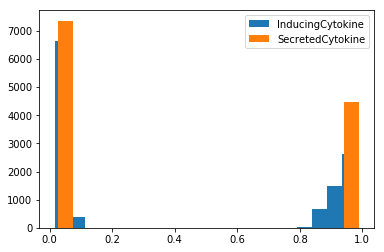

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
for c in res_train:
    plt.hist(res_train[c][2], bins=20, label=c)
    plt.legend()

In [29]:
# from IPython.display import display
# for c in res_train:
#     print(c)
#     display(res_train[c][0].learned_lf_stats())

In [39]:
??save_marginals

In [45]:
m = res_train[classes.inducing_cytokine.name][1]

In [46]:
type(m)

snorkel.annotations.csr_LabelMatrix

In [44]:
res_train[classes.inducing_cytokine.name][2]

array([0.94178632, 0.88969906, 0.94178632, ..., 0.03944329, 0.02989697,
       0.94178632])

In [47]:
??save_marginals

In [56]:
from snorkel.annotations import save_marginals

# Fetch the candidates for each class into a SINGLE list and do
# the same for the marginal arrays since the `save_marginals` function
# deletes all records (with no arguments for filters to avoid this) each time,
# making it impossible to call separately for each set of candidates
candidates, marginals = [], []
for c in res_train:
    X, y = res_train[c][1], res_train[c][2]
    candidates.extend([X.get_candidate(session, i) for i in range(X.shape[0])])
    marginals.append(y)
marginals = np.concatenate(marginals)
assert len(candidates) == len(marginals)
save_marginals(session, candidates, marginals)

Saved 23634 marginals


In [57]:
from snorkel.models import Marginal, Candidate

# Determine the candidate types for all saved marginals
cids = [m.candidate_id for m in session.query(Marginal).all()]
pd.DataFrame(
    session.query(Candidate.id, Candidate.type).filter(Candidate.id.in_(cids)),
    columns=['id', 'type']
).groupby('type').size()

type
inducing_cytokine    11817
secreted_cytokine    11817
dtype: int64

In [36]:
# _ = gen_model.error_analysis(session, L_dev, L_gold_dev)

In [37]:
# L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])